# py4DSTEM tutorial 3: Bragg disk detection

Finding the Bragg disks is the crux of most 4D-STEM analysis of crystals.  Here, we find the Bragg disks by matching the vacuum probe template we found previously to each diffraction pattern in our data.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected, find_Bragg_disks
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map, threshold_Braggpeaks
from py4DSTEM.file.datastructure import PointList, PointListArray
from py4DSTEM.file.io import FileBrowser, read, append

In [2]:
# Load data

fp = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Sample_LFP_datacube.h5"
dc = py4DSTEM.file.io.read(fp)                                                # Get the datacube

fp = "/home/ben/Desktop/Sample_LFP_datacube_processing.h5"
browser = FileBrowser(fp)
probe = browser.get_dataobject('probe')
probe_kernel = probe.data2D['probe_kernel']                                   # Get the probe kernel
browser.close()

/home/ben/Data/20180905_FePO4_unlithiated/h5/Sample_LFP_datacube.h5 is a py4DSTEM file, v0.4. Reading...


### Test parameters on a few diffraction patterns

In the cell below, we detect the Bragg disk positions in just a few diffraction patterns.  This is because the full calculation can be quite slow, so selecting just a few DPs allows us to quickly test parameters to figure out how best to locate the peaks.  It is worth taking your time at this step!

First, choose 3 scan positions to test.  I typically choose a very clean diffraction pattern, a very noisy one, and something in between.

Analyzed 3 diffraction patterns in 0h 0m 0s


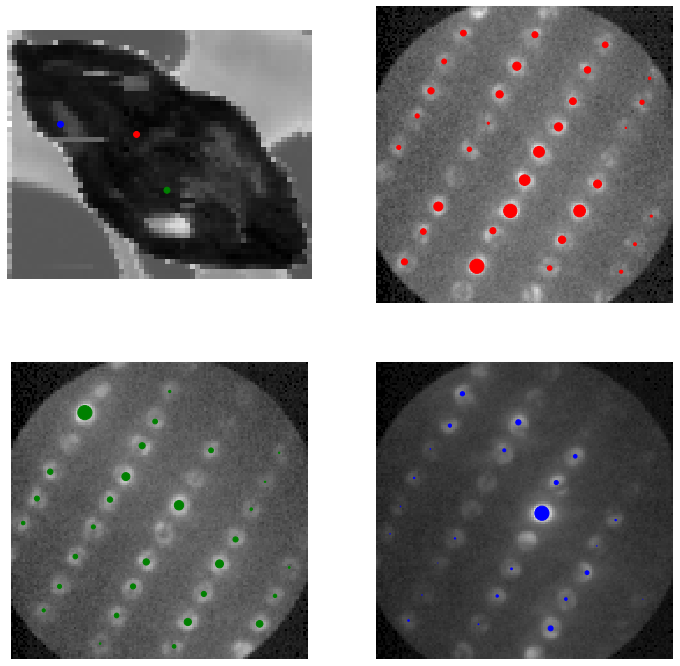

In [13]:
######## Parameters ########

# Select scan positions
Rxs=(20,31,18)
Rys=(25,31,10)

# Peak detection parameters
corrPower = .9
sigma = 2
edgeBoundary = 35
maxNumPeaks = 10
minPeakSpacing = 25
minRelativeIntensity = 0.01
subpixel = 'poly'

# Display parameters
power=0.3
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data4D[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data4D[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data4D[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Find Bragg disks in all diffraction patterns

Peform the full computation.  Be sure to copy the parameters you found worked best above!

In [14]:
######## Parameters ########

corrPower = .9
sigma = 2
edgeBoundary = 5
maxNumPeaks = 70
minPeakSpacing = 8
minRelativeIntensity = 0.0001
subpixel = 'poly'

verbose = True

############################

braggpeaks = find_Bragg_disks(dc, probe_kernel,
                              corrPower=corrPower,
                              sigma=sigma,
                              edgeBoundary=edgeBoundary,
                              minRelativeIntensity=minRelativeIntensity,
                              minPeakSpacing=minPeakSpacing,
                              maxNumPeaks=maxNumPeaks,
                              subpixel=subpixel,
                              verbose=verbose)
braggpeaks.name = 'braggpeaks'

Analyzing: |**************************************************| 100.0% Complete
Analyzed 2940 diffraction patterns in 0h 0m 12s


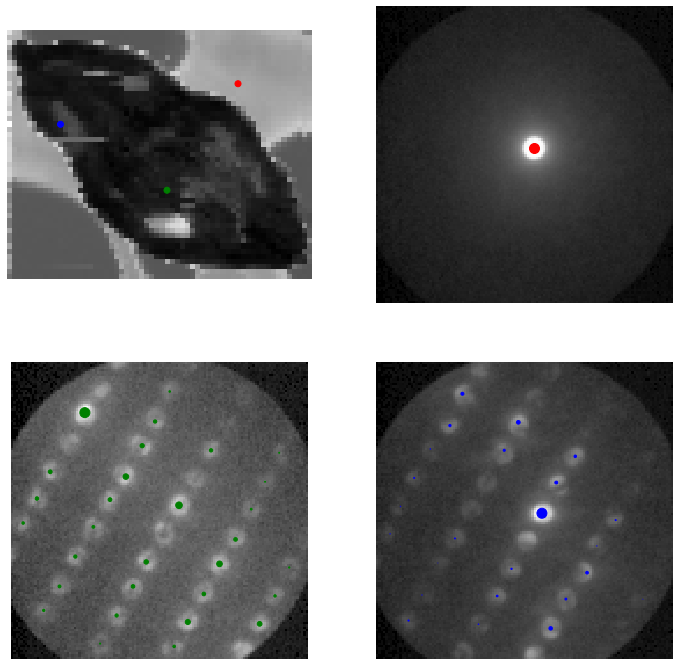

In [15]:
# Show results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = braggpeaks.get_pointlist(xs[0],ys[0])
peaks1 = braggpeaks.get_pointlist(xs[1],ys[1])
peaks2 = braggpeaks.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Save

In [16]:
# Append to running processing file

savepath = "/home/ben/Desktop/Sample_LFP_datacube_processing.h5"
append(braggpeaks, savepath)

Opening file /home/ben/Desktop/Sample_LFP_datacube_processing.h5...
Done.


### Get Bragg vector map

In [13]:
# Get Bragg vector map

braggvectormap = get_bragg_vector_map(braggpeaks,dc.Q_Nx,dc.Q_Ny)

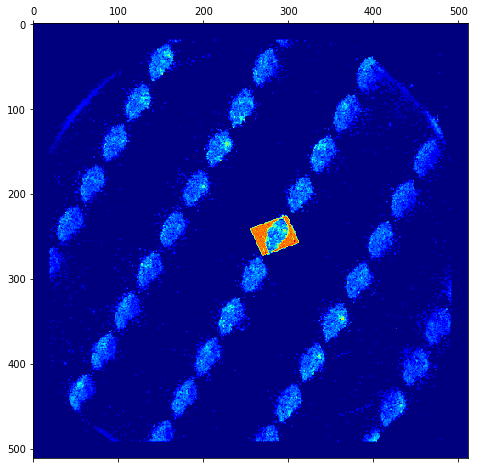

In [9]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**0.25,cmap='jet')
plt.show()

In [11]:
braggvectormap_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(braggvectormap, name='braggvectormap_uncorrected')

In [12]:
# Append to processing file

#fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append([braggpeaks,braggvectormap_diffslice], fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
